In [16]:
import cv2
from PIL import Image, ImageOps
import os
import numpy as np
import pandas as pd
import pickle
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img
import subprocess
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Clone the GitHub repository to a local directory
repo_url = "https://github.com/pongsapaks/Thai-handwrittingnumberproject.git"
repo_dir = "Thai-handwrittingnumberproject"
subprocess.run(["git", "clone", repo_url, repo_dir])

image_dir = os.path.join(repo_dir, "raw")
desired_width = 28
desired_height = 28

# Fetch all image files within the directory and its subfolders
image_files = []
for root, dirs, files in os.walk(image_dir):
    for file in files:
        if file.endswith((".jpg", ".jpeg", ".png")):
            image_files.append(os.path.join(root, file))

# Initialize lists to store the image data and labels
X = []
Y = []

#Prepare the dataset
def make_dataset():
    #global X, Y  # Declare X and Y as global variables
    
    for image_path in image_files:
        img = cv2.imread(image_path)
        
        # Skip empty or invalid images
        if img is None:
            #print(f"Failed to read image: {image_path}")
            continue
        
        img = cv2.resize(img, (desired_width, desired_height))
        if img.ndim == 2:  # Grayscale image
            img = Image.fromarray(img)
        elif img.ndim == 3:  # Color image
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(img)
        else:
            print(f"Invalid image format: {image_path}")
            continue
        
        img = ImageOps.invert(img)
        category = os.path.basename(os.path.dirname(image_path))
        X.append(np.array(img) / 255.0)  # Convert to numpy array and normalize
        Y.append(category)

    # Convert the lists to numpy arrays for further processing
    X = np.array(X)  # X = image
    Y = np.array(Y)  # Y = labels
    data = {"X": X, "Y": Y}
    pickle.dump(data, open("thainumber_{}.pkl".format(desired_width), "wb"), protocol=2)

def load_dataset(size=28):
    data = pickle.load(open("thainumber_{}.pkl".format(size), "rb"))
    X = data['X']
    Y = data['Y']
    return X, Y

def prepare_input(file):
    img = load_img(file, grayscale=True, target_size=(28, 28))
    img = ImageOps.invert(img)
    x = img_to_array(img)
    return x

def img_cloud_dataset(size=28):
    X, Y = load_dataset(size)
    x = 0
    y = 0
    new_im = Image.new('L', (size * 50, size * math.ceil(X.shape[0] / 50)))
    for i in range(0, X.shape[0]):
        if (i != 0 and i % 50 == 0):
            y += size
            x = 0

        img = np.expand_dims(X[i], axis=-1)  # Add channel dimension
        if img.ndim == 2:  # Grayscale image
            img = np.concatenate([img] * 3, axis=-1)  # Convert to 3 channels
        elif img.ndim == 3 and img.shape[2] == 1:  # Grayscale image with channel dimension
            img = np.concatenate([img] * 3, axis=-1)  # Convert to 3 channels
        elif img.ndim == 3 and img.shape[2] == 3:  # Color image with 3 channels
            pass  # No conversion needed
        else:
            #print(f"Invalid image format: {image_path}")
            continue

        im = array_to_img(img)
        new_im.paste(im, (x, y))
        x += size
    return new_im

# Save the image cloud dataset
new_im = img_cloud_dataset(desired_width)
new_im.save("cloud_dataset_{}.png".format(desired_width))

In [17]:
def train_model(X, Y):
    # Split the dataset into training and validation sets
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Reshape the input data for Random Forest classifier
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_val = X_val.reshape(X_val.shape[0], -1)

    # Initialize the Random Forest classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)

    # Train the classifier
    clf.fit(X_train, Y_train)

    # Make predictions on the validation set
    Y_pred = clf.predict(X_val)

     # Calculate the accuracy of the model
    accuracy = (Y_pred == Y_val).mean()
    print("Validation Accuracy:", accuracy)

In [18]:
X, Y = load_dataset(desired_width)

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


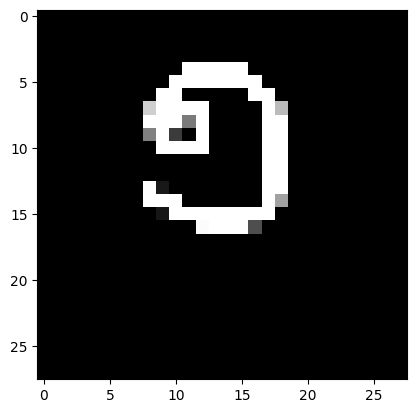

In [20]:
import matplotlib.pyplot as plt
plt.imshow(X[1], cmap='gray', vmin=0, vmax=255)

In [33]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import cv2
import numpy as np
import pickle

model = pickle.load(open("thainumber_28.pkl", "rb"))
app = dash.Dash(__name__)

app.layout = html.Div(
    children=[
        html.H1("Thai Handwritten Number Recognition"),
        dcc.Upload(
            id="upload-image",
            children=html.Div(["Drag and Drop or ", html.A("Select Image")]),
            style={
                "width": "50%",
                "height": "50px",
                "lineHeight": "50px",
                "borderWidth": "1px",
                "borderStyle": "dashed",
                "borderRadius": "5px",
                "textAlign": "center",
                "margin": "10px",
            },
            multiple=False,
        ),
        html.Div(id="output-prediction"),
    ]
)

@app.callback(
    Output("output-prediction", "children"),
    [Input("upload-image", "contents")],
)
def predict_number(contents):
    if contents is not None:
        # Preprocess user input
        input_img = prepare_input(contents)

        # Make a prediction using the loaded model
        prediction = model.predict(input_img)

        # Display the prediction
        return html.H2(f"Predicted number: {prediction[0]}")
    else:
        return html.Div()
    
def prepare_input(contents):
    content_type, content_string = contents.split(",")

    # Decode the base64 encoded image
    decoded_img = base64.b64decode(content_string)

    # Convert the image to numpy array
    img_array = np.frombuffer(decoded_img, np.uint8)

    # Read the image using OpenCV
    img = cv2.imdecode(img_array, cv2.IMREAD_GRAYSCALE)

    # Preprocess the image
    img = cv2.resize(img, (28, 28))
    img = img.reshape(1, -1).astype(np.float32) / 255.0

    return img

if __name__ == '__main__':
    app.run_server(debug=True)

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__'
 * Debug mode: on


SystemExit: 1

c:\Users\Karuntarat\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3441: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [34]:
%tb

SystemExit: 1